In [1]:
import pandas as pd
import numpy as np
import arviz as az
import graphviz as gz
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from scipy.special import expit as logistic

sns.set()
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data_path = 'data/processed_data.csv'

In [3]:
data = pd.read_csv(data_path)

/tmp/ipykernel_3492/560202589.py:1: DtypeWarning: Columns (579,629,630,631,664,665,666,667,668,669,670,684,685,686,687,688,714) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [4]:
data.head()

,Unnamed: 0,CCAA,TMUNI,IDENTHOGAR,NORDEN,SEXO,EDAD,INFOR_DISC,INFOR_HOG,INFOR_RELAC,...,B_15_3,B_15_4,B_15_5,B_15_6,B_15_7,B_15_8,B_15_9,B_15_10,B_16,FACTOR
0,1,16,4,7,1,1,56,1,,,...,,,,,,,,,,222.916
1,2,16,4,10,2,1,67,1,,,...,,,,,,,,,,296.805
2,3,16,5,21,1,2,52,1,,,...,,,,,,,,,,300.734
3,4,16,5,24,3,1,37,6,1,3,...,,,,,,,,,,326.648
4,5,16,5,30,4,1,56,1,,,...,,,,,,,,,,324.750


In [5]:
relevant_columns = ['SEXO', 'EDAD', 'H_14']

In [6]:
data = data[relevant_columns]

In [7]:
data = data.rename(columns={'SEXO': 'sex', 'EDAD': 'age', 'H_14': 'discrimination'})

In [8]:
data['sex'] -= 1

In [9]:
data.head()

,sex,age,discrimination
0,0,56,1
1,0,67,1
2,1,52,1
3,0,37,1
4,0,56,2


In [10]:
data.discrimination.unique()

array([1, 2, 9, 3, 4])

In [11]:
data.sex.unique()

array([0, 1])

In [12]:
data.age.sort_values().unique()

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 104, 106])

In [13]:
data = data.query('discrimination != 9')

In [14]:
sample = data.sample(2000)

In [15]:
data.groupby('sex').discrimination.mean()

sex
0    1.136951
1    1.104550
Name: discrimination, dtype: float64

### Linear Regression, Gaussian Likelihood

In [31]:
with pm.Model() as model:
    
    # Uninformative Priors
    alpha = pm.Normal('alpha', mu=0, sigma=0.5, shape=2)
    beta = pm.Normal('beta', mu=0, sigma=0.5, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=0.5)

    # IDs
    sex_id = pm.intX(pm.ConstantData('sex_id', sample['sex']))

    # Expected value of outcome
    mu = alpha[sex_id] + beta[sex_id]*(sample['age']/sample.age.max())
    # Likelihood
    discrimination = pm.Normal('discrimination', mu=mu, sigma=sigma, observed=(sample['discrimination']-1))

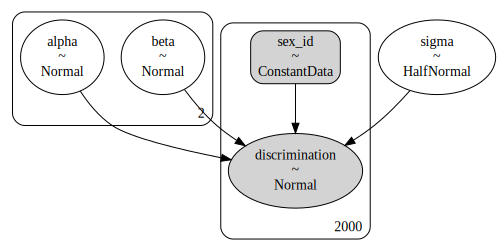

In [32]:
pm.model_to_graphviz(model)

In [33]:
with model:
    prior = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [alpha, beta, discrimination, sigma]


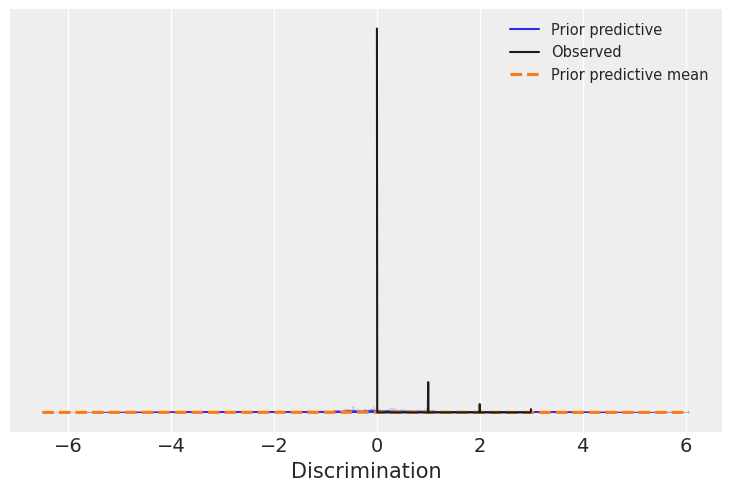

In [34]:
az.plot_ppc(prior, group='prior')
plt.xlabel('Discrimination')
plt.show()

In [41]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(random_seed=rng)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [discrimination]


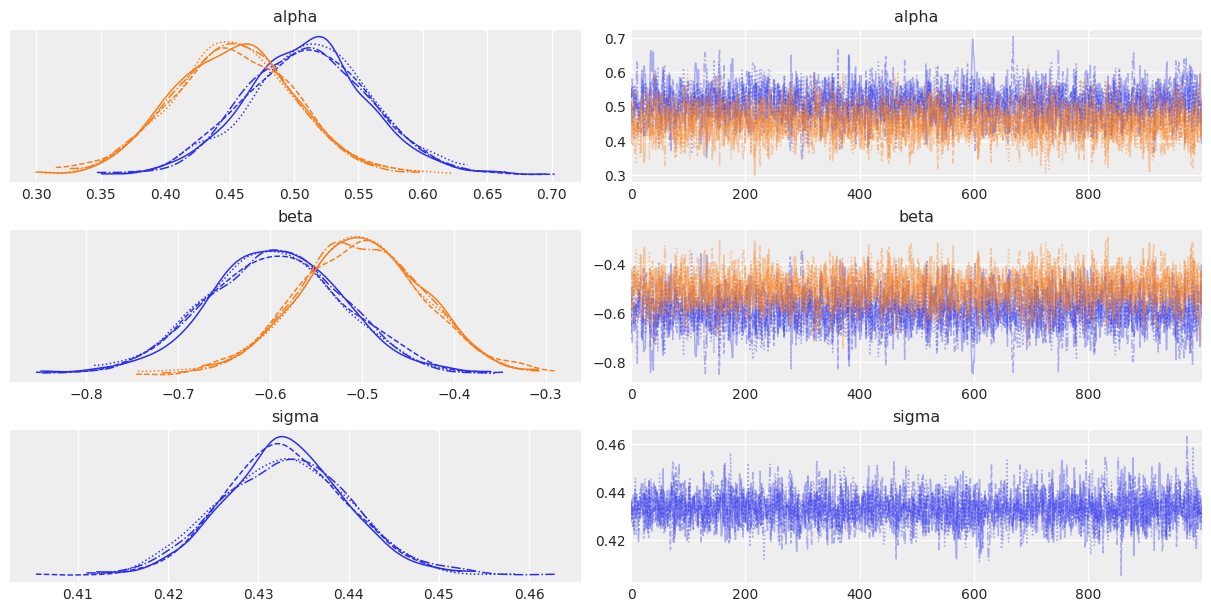

In [42]:
az.plot_trace(idata);

In [43]:
az.summary(idata, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.51,0.05,0.42,0.60,0.0,0.0,1970.48,1322.80,1.0
alpha[1],0.45,0.05,0.36,0.54,0.0,0.0,2167.38,1980.80,1.0
beta[0],-0.60,0.08,-0.73,-0.45,0.0,0.0,1958.64,1375.02,1.0
beta[1],-0.50,0.07,-0.63,-0.37,0.0,0.0,2281.78,2355.35,1.0
sigma,0.43,0.01,0.42,0.45,0.0,0.0,3117.66,2083.21,1.0


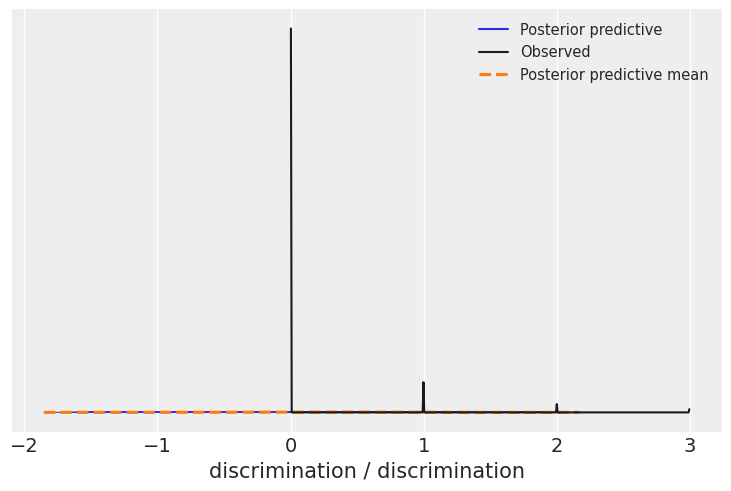

In [44]:
az.plot_ppc(idata, num_pp_samples=500)
plt.show()

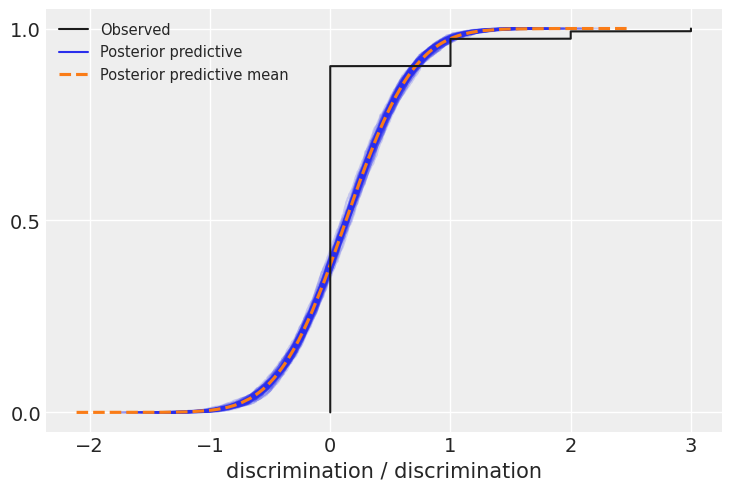

In [45]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')
plt.show()

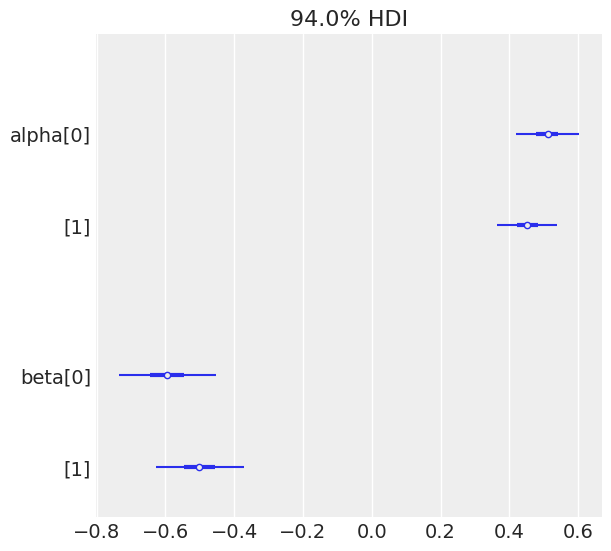

In [50]:
az.plot_forest(idata, var_names=['alpha', 'beta'], combined=True)
plt.show()

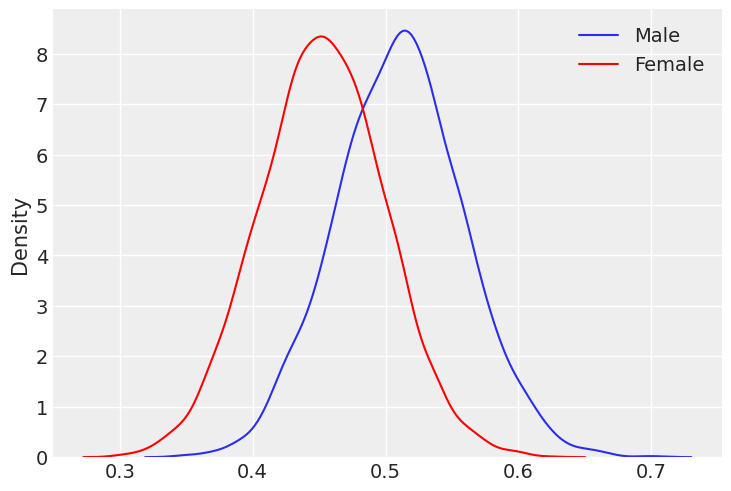

In [85]:
sns.kdeplot(np.concatenate(idata.posterior['alpha'][:, :, 0]), label='Male')
sns.kdeplot(np.concatenate(idata.posterior['alpha'][:, :, 1]), label='Female', color='red')
plt.legend()
plt.show()

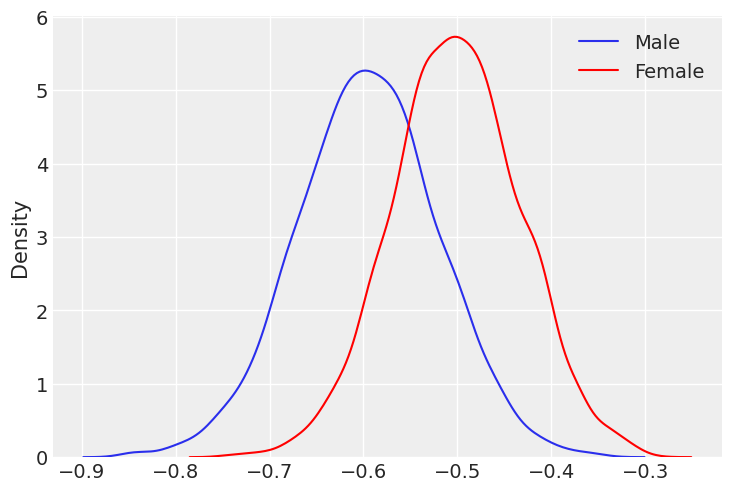

In [86]:
sns.kdeplot(np.concatenate(idata.posterior['beta'][:, :, 0]), label='Male')
sns.kdeplot(np.concatenate(idata.posterior['beta'][:, :, 1]), label='Female', color='red')
plt.legend()
plt.show()

In [88]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [89]:
idata.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, alpha_dim_0: 2, beta_dim_0: 2)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * alpha_dim_0  (alpha_dim_0) int64 0 1
  * beta_dim_0   (beta_dim_0) int64 0 1
Data variables:
    alpha        (chain, draw, alpha_dim_0) float64 0.5476 0.422 ... 0.5049
    beta         (chain, draw, beta_dim_0) float64 -0.63 -0.4599 ... -0.573
    sigma        (chain, draw) float64 0.4351 0.4289 0.4328 ... 0.4309 0.4336
Attributes:
    created_at:                 2023-09-07T07:32:11.018558
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              14.463832378387451
    tuning_steps:               1000

In [93]:
male_alpha = np.concatenate(idata.posterior['alpha'][:, :, 0])
male_beta = np.concatenate(idata.posterior['beta'][:, :, 0])

female_alpha = np.concatenate(idata.posterior['alpha'][:, :, 1])
female_beta = np.concatenate(idata.posterior['beta'][:, :, 1])

In [97]:
male_alpha.mean(), female_alpha.mean()

(0.5106010545018019, 0.45246557022833817)

In [104]:
age_range = np.arange(data.age.min(), data.age.max()+1, 1)/data.age.max()

In [140]:
disc_male = (male_alpha + age_range[:, None]*male_beta).T
disc_female = (female_alpha + age_range[:, None]*female_beta).T

/home/ignacio/Projects/articles/survey_disability/env/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/ignacio/Projects/articles/survey_disability/env/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


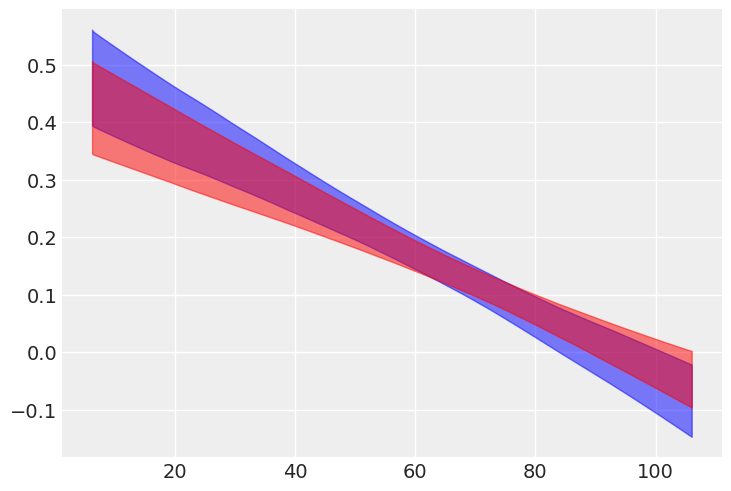

In [148]:
az.plot_hdi(age_range*data.age.max(), disc_male, color='blue')
az.plot_hdi(age_range*data.age.max(), disc_female, color='red')
plt.show()

/home/ignacio/Projects/articles/survey_disability/env/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/ignacio/Projects/articles/survey_disability/env/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


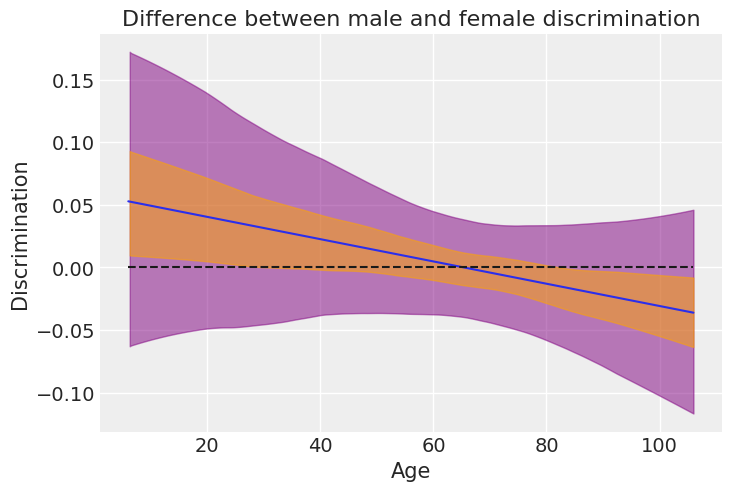

In [169]:
az.plot_hdi(age_range*data.age.max(), disc_male - disc_female, color='purple', hdi_prob=0.95)
az.plot_hdi(age_range*data.age.max(), disc_male - disc_female, color='orange', hdi_prob=0.50)
plt.plot(age_range*data.age.max(),(disc_male - disc_female).mean(axis=0))
plt.title('Difference between male and female discrimination')
plt.ylabel('Discrimination')
plt.xlabel('Age')
plt.hlines(xmin=data.age.min(), xmax=data.age.max(), y=0, color='k', linestyles='--')
plt.show()

TODO

1. Gaussian Process for Age
2. Ordered logistic, linear model
3. Ordered logistic, gaussian process